In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

train = pd.read_csv('/content/drive/MyDrive/YBIGTA/ML/과제/movies_train.csv')
test = pd.read_csv('/content/drive/MyDrive/YBIGTA/ML/과제/movies_test.csv')

# 데이터 전처리

In [3]:
# 결측치가 많은 데이터 제거
train = train.drop(['dir_prev_bfnum'],axis = 1)
test =  test.drop(['dir_prev_bfnum'],axis = 1)

In [4]:
# 감독명 : 너무 다양해서 제거
train = train.drop(['director'],axis = 1)
test = test.drop(['director'],axis = 1)

In [5]:
# 제목 : 의미가 없기 때문에 제거
train = train.drop(['title'],axis= 1)
test = test.drop(['title'],axis= 1)

In [6]:
# 상위 5개의 배급사를 제외하고 '기타'로처리
distributor_list = train.distributor.value_counts()[:5]
def func(distributor):
    if distributor in distributor_list:
        return distributor
    else:
        return '기타'

train['distributor'] = train['distributor'].apply(lambda x : func(x))
test['distributor'] = test['distributor'].apply(lambda x : func(x))

In [7]:
# 개봉일을 바탕으로 년,월 변수 생성
train['년'] = train['release_time'].apply(lambda x: int(x[:4]))
train['월'] = train['release_time'].apply(lambda x: int(x[5:7]))
train =  train.drop(['release_time'],axis = 1)

test['년'] = test['release_time'].apply(lambda x: int(x[:4]))
test['월'] = test['release_time'].apply(lambda x: int(x[5:7]))
test =  test.drop(['release_time'],axis = 1)

In [8]:
# 원핫 인코딩
train = pd.get_dummies(train)
test = pd.get_dummies(test)

# 모델 생성 및 예측(과제부분)

In [9]:
# 데이터 확인
pd.set_option('display.max_columns',None)
train.head()

,time,dir_prev_num,num_staff,num_actor,box_off_num,년,월,distributor_(주)NEW,distributor_(주)마운틴픽쳐스,distributor_(주)쇼박스,distributor_CJ 엔터테인먼트,distributor_기타,distributor_롯데엔터테인먼트,genre_SF,genre_공포,genre_느와르,genre_다큐멘터리,genre_드라마,genre_멜로/로맨스,genre_뮤지컬,genre_미스터리,genre_서스펜스,genre_애니메이션,genre_액션,genre_코미디,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,96,0,91,2,23398,2012,11,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,130,2,387,3,7072501,2015,11,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,123,4,343,4,6959083,2013,6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,101,2,20,6,217866,2012,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,108,1,251,2,483387,2010,11,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


##Decision Tree

In [10]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor

In [11]:
from sklearn.model_selection import train_test_split

# Train data Features 
train_x = train.drop(['box_off_num'],axis= 1)
# Train data Target
train_y = train['box_off_num']

# Split (Train data & Validataion data)
train_features, test_features , train_target, test_target = train_test_split(
    train_x, train_y, test_size = 0.2, random_state = 101)

In [12]:
DTRegressor = DecisionTreeRegressor()
DTRegressor.fit(train_features, train_target)
pred = DTRegressor.predict(test_features)

In [13]:
from sklearn.metrics import r2_score, mean_squared_error
print('R squared: %.3f' % r2_score(test_target, pred))
print('MSE: %.3f' % mean_squared_error(test_target,pred))

R squared: -0.232
MSE: 2938854899132.808


In [14]:
DTRegressor.get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [15]:
from sklearn.model_selection import GridSearchCV
param_range1 = [1,2,3,4,5,6,7,8]
param_range2 = [3, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18]
param_range3 = ['mse', 'mae'] # 'explained_variance' 등도 가능

param_grid = [{'max_depth': param_range1,
              'min_samples_leaf': param_range2,
              'criterion': param_range3}]

gs = GridSearchCV(estimator = DTRegressor,
                 param_grid = param_grid, # 찾고자하는 파라미터. dictionary 형식
                 scoring = 'neg_mean_squared_error', # Regression 일때 'neg_mean_squared_error','r2' 등
                 cv=5,
                 n_jobs= -1)

gs = gs.fit(train_features, train_target)

print(-gs.best_score_)
print(gs.best_params_)

2606799009543.0195
{'criterion': 'mae', 'max_depth': 4, 'min_samples_leaf': 15}


/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


In [16]:
best_tree = gs.best_estimator_ # 최적의 파라미터로 모델 생성
best_tree.fit(train_features, train_target)

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


DecisionTreeRegressor(criterion='mae', max_depth=4, min_samples_leaf=15)

In [17]:
best_pred = best_tree.predict(test_features)
print('R squared: %.3f' % r2_score(test_target, best_pred))
print('MSE: %.3f' % mean_squared_error(test_target,best_pred))

R squared: 0.445
MSE: 1322860618036.881


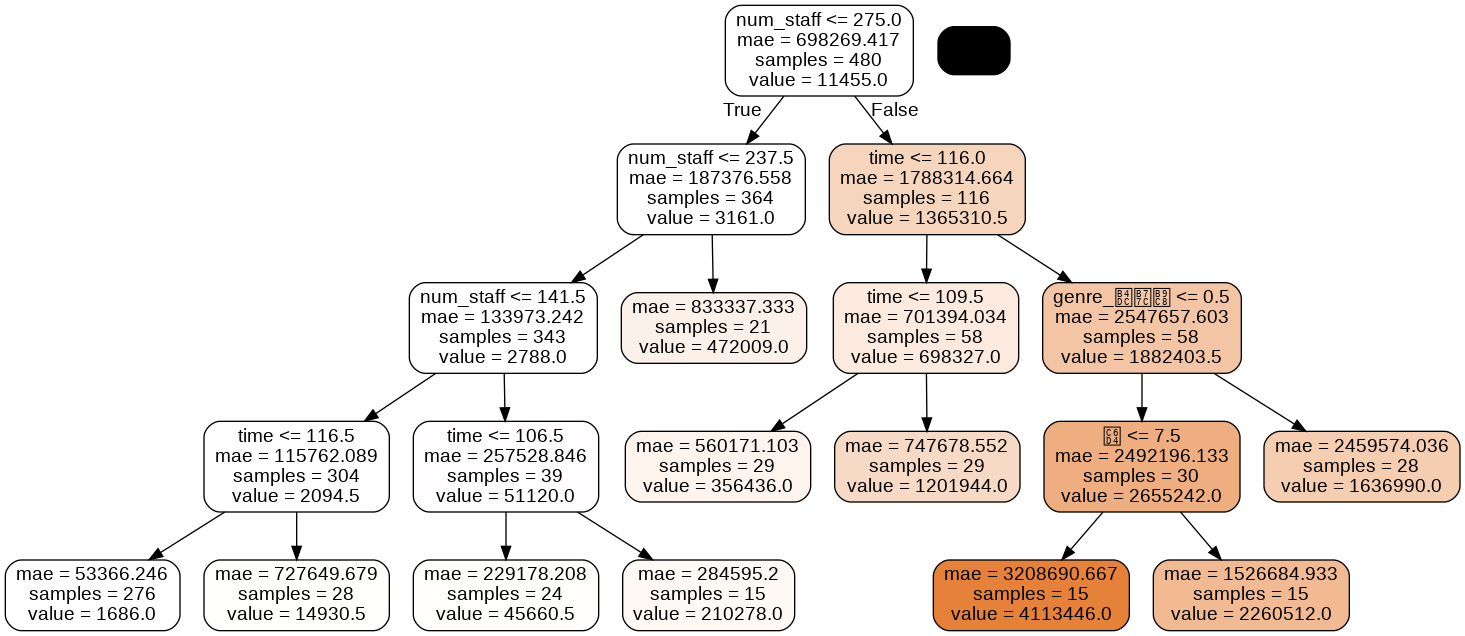

In [18]:
#DecisionTree 시각화, regression이라 그런지 매우 복잡하다
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus

import numpy as np
feature_names = train_features.columns.tolist()
target_name = np.array(['price'])

dot_data_best = export_graphviz(best_tree,
                          filled = True,
                          rounded = True,
                          class_names = target_name,
                          feature_names = feature_names,
                          out_file = None)
dt_graph_best = pydotplus.graph_from_dot_data(dot_data_best)
Image(dt_graph_best.create_png())

##Boosting

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

In [20]:
params = {
    "n_estimators": 50,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
GBRegressor = GradientBoostingRegressor(**params)
GBRegressor.fit(train_features,train_target)
GBpred = GBRegressor.predict(test_features)
print('R squared: %.3f' % r2_score(test_target, GBpred))
print('MSE: %.3f' % mean_squared_error(test_target,GBpred))

R squared: 0.141
MSE: 2048006931777.032


In [21]:
param_range1 = [1,2,3,4,5,6,7,8]
param_range2 = [5, 10, 15, 20]

param_grid2 = [{'max_depth': param_range1,
              'min_samples_split': param_range2}]

gs2 = GridSearchCV(estimator = GBRegressor,
                 param_grid = param_grid2, # 찾고자하는 파라미터. dictionary 형식
                 scoring = 'neg_mean_squared_error', # Regression 일때 'neg_mean_squared_error','r2' 등
                 cv=5,
                 n_jobs= -1)

gs2 = gs2.fit(train_features, train_target)

print(-gs2.best_score_)
print(gs2.best_params_)

2574488526119.54
{'max_depth': 4, 'min_samples_split': 15}


In [22]:
best_tree2 = gs2.best_estimator_ # 최적의 파라미터로 모델 생성
best_tree2.fit(train_features, train_target)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=15,
                          n_estimators=50)

In [23]:
best_pred2 = best_tree2.predict(test_features)
print('R squared: %.3f' % r2_score(test_target, best_pred2))
print('MSE: %.3f' % mean_squared_error(test_target,best_pred2))

R squared: 0.136
MSE: 2059833381202.128


##XGBRoost

In [24]:
import xgboost as xgb

In [25]:
XGBRegressor = xgb.XGBRegressor(n_estimators=100, learning_rate=0.01, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=4)

In [26]:
XGBRegressor.fit(train_features,train_target)
XGBpred = XGBRegressor.predict(test_features)
print('R squared: %.3f' % r2_score(test_target, XGBpred))
print('MSE: %.3f' % mean_squared_error(test_target,XGBpred))

[07:39:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R squared: 0.205
MSE: 1895359752933.236


# 제출

###R-squared 값이 가장 높은 Decision Tree 모델로 결정 

In [27]:
pred = best_tree.predict(test)

In [28]:
submission = pd.read_csv('/content/drive/MyDrive/YBIGTA/ML/과제/submission.csv')
submission

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0
...,...,...
238,해에게서 소년에게,0
239,울보 권투부,0
240,어떤살인,0
241,말하지 못한 비밀,0


In [29]:
submission['box_off_num'] = pred

In [30]:
submission

,title,box_off_num
0,용서는 없다,4113446.0
1,아빠가 여자를 좋아해,472009.0
2,하모니,1201944.0
3,의형제,1201944.0
4,평행 이론,1201944.0
...,...,...
238,해에게서 소년에게,1686.0
239,울보 권투부,1686.0
240,어떤살인,210278.0
241,말하지 못한 비밀,1686.0


In [31]:
submission.to_csv('/content/drive/MyDrive/YBIGTA/ML/과제/베이스라인.csv',index = True)

# 제출 점수(과제부분)

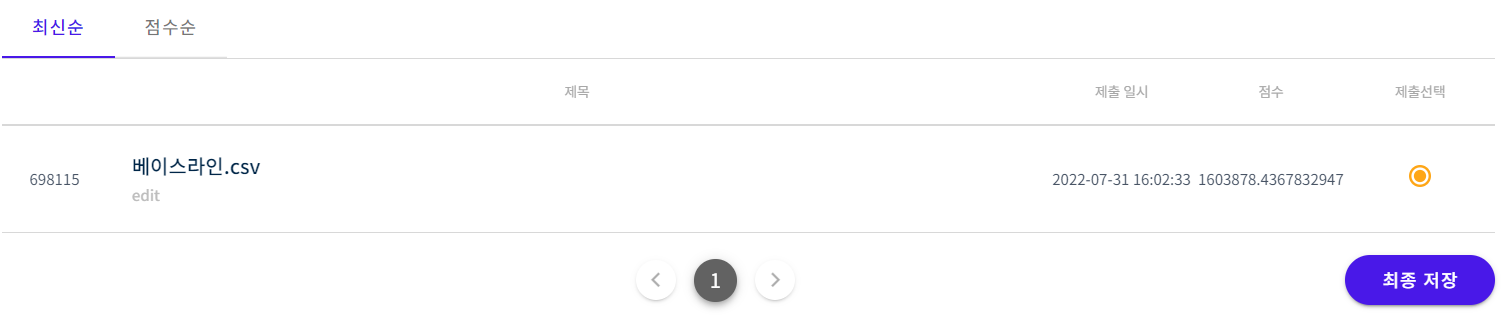